## ЛР 8
## (Медведев К.В. М8О-406Б-21)

### Проведение исследований моделями обнаружения и распознавания объектов


**План работ:**

1. Выбор начальных условий:
    - Выбрать набор данных для задачи классификации
    - Выбрать метрики качества и обосновать их выбор

2. Создание бейзлайна и оценка качества:
    - Обучить модели ultralytics (семейство моделей YOLO)
    - Оценить качество моделей по выбранным метрикам на выбранном наборе данных

3. Улучшение бейзлайна:
    - Сформулировать гипотезы (аугментации данных, подбор моделей, подбор гиперпараметров и т.д.)
    - Сформировать улучшенный бейзлайн по результатам проверки гипотез
    - Обучить модели с улучшенным бейзлайном на выбранном наборе данных
    - Оценить качество моделей с улучшенным бейзлайном по выбранным метрикам на выбранном наборе данных

4. Имплементация алгоритма машинного обучения:
    - Самостоятельно имплементировать модели машинного обучения
    - Обучить имплементированные модели на выбранном наборе данных
    - Оценить качество имплементированных моделей
5. 	Сделать выводы




# 1. Выбор начальных условий

Загрузка датасета

In [49]:
import os
import kagglehub
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from shutil import copyfile
import matplotlib.pyplot as plt
from PIL import Image

import ultralytics
from ultralytics import YOLO
ultralytics.checks()

path = kagglehub.dataset_download("outliersloop/footballyolov8")

print("Path to dataset files:", path)

# Сбор путей к изображениям и аннотациям
ipaths = []
tpaths = []

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.lower().endswith('.jpg'):
            ipaths.append(os.path.join(dirname, filename))
        elif filename.lower().endswith('.txt'):
            tpaths.append(os.path.join(dirname, filename))

# Сортировка для упорядочивания
ipaths = sorted(ipaths)
tpaths = sorted(tpaths)

print(ipaths[0])
print(len(ipaths))


Ultralytics 8.3.139 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 42.0/112.6 GB disk)
Path to dataset files: /kaggle/input/footballyolov8
/kaggle/input/footballyolov8/22d_f_120_6ty.jpg
66


Загрузка аннотации объектов из `.txt` файлов в формате YOLO, где каждая строка описывает один объект в виде: `<class_id> <x_center> <y_center> <width> <height>` с нормализованными координатами.

Он сохраняет содержимое файлов в список `boxdata` и соответствующие имена файлов (без расширения) в список `boxfile`. В конце выводятся аннотации из первого файла.


In [50]:
boxdata=[]
boxfile=[]
for i in range(len(tpaths)):
    file=tpaths[i]
    boxdata+=[np.loadtxt(file)]
    boxfile+=[file[0:-4].split('/')[-1]]
print(boxdata[0])

[[          0      0.2849     0.21019    0.021875    0.087963]
 [          0     0.41875     0.27546    0.017188    0.097222]
 [          0     0.32904     0.35486    0.022135     0.10694]
 [          0     0.38997     0.50671    0.032031    0.099537]
 [          0     0.42513      0.4794     0.03151    0.099537]
 [          0      0.4849     0.41412    0.034896    0.090278]
 [          0     0.48398     0.52523    0.036719    0.091204]
 [          0     0.47721     0.58102    0.048698    0.081481]
 [          1     0.64805     0.45532     0.01276    0.022685]
 [          0     0.56875     0.21736    0.019271    0.078241]
 [          0     0.58646     0.19745    0.021354    0.077315]
 [          0     0.68919     0.40833    0.033594    0.097222]
 [          0     0.95065     0.38518    0.029948     0.07963]]


Формирование единого `DataFrame` `BOX`, содержащего все аннотации из списка `boxdata`, добавляя к каждой строке имя соответствующего изображения из `boxfile`.

Он обрабатывает как случаи с одной аннотацией в файле (`np.float64`), так и с несколькими (2D-массив). В результате создается таблица `BOX2`, где каждая строка представляет одну bounding box-аннотацию с указанием класса, координат и имени файла. Индексы сбрасываются, и итоговая таблица отображается.


In [51]:
BOX=pd.DataFrame()

for i in range(len(boxdata)):
    if type(boxdata[i][0])==np.float64:
        add=pd.DataFrame([boxdata[i]])
        add[5]=boxfile[i]
        BOX=pd.concat([BOX,add])
    else:
        add=pd.DataFrame(boxdata[i])
        add[5]=boxfile[i]
        BOX=pd.concat([BOX,add])

BOX2=BOX.reset_index(drop=True)
display(BOX2)

0         1         2         3         4              5
0    0.0  0.284896  0.210185  0.021875  0.087963  22d_f_120_6ty
1    0.0  0.418750  0.275463  0.017188  0.097222  22d_f_120_6ty
2    0.0  0.329036  0.354861  0.022135  0.106944  22d_f_120_6ty
3    0.0  0.389974  0.506713  0.032031  0.099537  22d_f_120_6ty
4    0.0  0.425130  0.479398  0.031510  0.099537  22d_f_120_6ty
..   ...       ...       ...       ...       ...            ...
745  0.0  0.501563  0.500926  0.047917  0.239815        we_f_50
746  0.0  0.453125  0.530556  0.035417  0.159259        we_f_50
747  0.0  0.404427  0.510417  0.070312  0.213426        we_f_50
748  0.0  0.384375  0.550231  0.018229  0.110648        we_f_50
749  1.0  0.601693  0.591204  0.014844  0.028704        we_f_50

[750 rows x 6 columns]

Замена числовых меток классов в первом столбце таблицы `BOX2` на строковые названия, используя словарь `class_map`, где `0` соответствует "player", а `1` — "football".


In [52]:
class_map = {0:'player', 1:'football'}
for i in range(len(BOX2)):
    BOX2.iloc[i,0]=class_map[int(BOX2.iloc[i,0])]
display(BOX2)
display(BOX2.iloc[:,0].value_counts())

0         1         2         3         4              5
0      player  0.284896  0.210185  0.021875  0.087963  22d_f_120_6ty
1      player  0.418750  0.275463  0.017188  0.097222  22d_f_120_6ty
2      player  0.329036  0.354861  0.022135  0.106944  22d_f_120_6ty
3      player  0.389974  0.506713  0.032031  0.099537  22d_f_120_6ty
4      player  0.425130  0.479398  0.031510  0.099537  22d_f_120_6ty
..        ...       ...       ...       ...       ...            ...
745    player  0.501563  0.500926  0.047917  0.239815        we_f_50
746    player  0.453125  0.530556  0.035417  0.159259        we_f_50
747    player  0.404427  0.510417  0.070312  0.213426        we_f_50
748    player  0.384375  0.550231  0.018229  0.110648        we_f_50
749  football  0.601693  0.591204  0.014844  0.028704        we_f_50

[750 rows x 6 columns]

0
player      701
football     49
Name: count, dtype: int64

Функция `draw_box(n0)` загружает изображение по индексу `n0`, находит соответствующие ему аннотации в `BOX2` и рисует прямоугольники:
- зеленым — для объектов класса "player",
- красным — для "football".

Координаты YOLO-аннотаций преобразуются из нормализованных значений в абсолютные пиксели. Далее цикл проходит по всем изображениям в `ipaths`, вызывает `draw_box()` и сохраняет результаты в список `images1`.


100%|██████████| 66/66 [00:03<00:00, 20.38it/s]


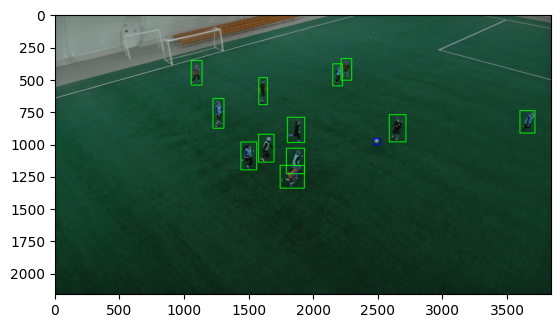

In [53]:
def draw_box(n0):

    ipath=ipaths[n0]
    image=cv2.imread(ipath)
    H,W=image.shape[0],image.shape[1]
    file=ipath[0:-4].split('/')[-1]

    if BOX2[BOX2[5]==file] is not None:
        box=BOX2[BOX2[5]==file]
        box=box.reset_index(drop=True)

        for i in range(len(box)):
            label=box.iloc[i,0]
            x=box.iloc[i,1]
            y=box.iloc[i,2]
            w=box.iloc[i,3]
            h=box.iloc[i,4]
            x0=((x-w/2)*W).astype(int)
            y0=((y-h/2)*H).astype(int)
            x1=((x+w/2)*W).astype(int)
            y1=((y+h/2)*H).astype(int)
            if label=='player':
                cv2.rectangle(image,(x0,y0),(x1,y1),(0,255,0),5) #green
            elif label=='football':
                cv2.rectangle(image,(x0,y0),(x1,y1),(0,0,255),5) #blue


    return image

images1=[]
for i in tqdm(range(len(ipaths))):
    images1+=[draw_box(i)]

# Вывод примера
plt.imshow(images1[0])
plt.show()

Для оценки качества модели детекции объектов будут использоваться следующие метрики:

- **mAP50 (mean Average Precision IoU=0.50)**
- **mAP@50-95**

**Average Precision (AP)** — это площадь под кривой Precision-Recall для одного класса.

**mAP50** — среднее значение AP по всем классам при IoU=0.5.

Эта метрика измеряет среднее значение `Average Precision (AP)` для всех классов при фиксированном пороге перекрытия **IoU = 0.5**.

**mAP50-95** - более строгая и детализированная метрика: усреднение значений `AP` по нескольким порогам IoU от `0.50` до `0.95` с шагом `0.05`.

Метрика учитывает точность детекции при различных уровнях строгости, обеспечивая более объективную оценку модели.



# 2. Создание бейзлайна и оценка качества

In [54]:
os.makedirs('datasets', exist_ok=True)
os.makedirs('datasets/train', exist_ok=True)
os.makedirs('datasets/valid', exist_ok=True)
os.makedirs('datasets/test', exist_ok=True)

for i in range(len(ipaths)):
    ipath=ipaths[i]
    ifile=ipath.split('/')[-1]
    tpath=tpaths[i]
    tfile=tpath.split('/')[-1]
    if i%3==0:
        copyfile(ipath, f'datasets/train/{ifile}')
        copyfile(tpath, f'datasets/train/{tfile}')
    elif i%3==1:
        copyfile(ipath, f'datasets/valid/{ifile}')
        copyfile(tpath, f'datasets/valid/{tfile}')
    else:
        copyfile(ipath, f'datasets/test/{ifile}')
        copyfile(tpath, f'datasets/test/{tfile}')

In [55]:
import yaml

football_yaml = dict(
    train ='train',
    val ='valid',
    test='test',
    nc =2,
    names =['player','football']
)

with open('football.yaml', 'w') as outfile:
    yaml.dump(football_yaml, outfile, default_flow_style=True)


In [56]:
%cat football.yaml

football_yaml = dict(
    train ='datasets/train',
    val ='datasets/valid',
    test='datasets/test',
    nc = 2,
    names = ['player','football']
)

with open('football.yaml', 'w') as outfile:
    yaml.dump(football_yaml, outfile, default_flow_style=True)


{names: [player, football], nc: 2, test: test, train: train, val: valid}


In [11]:
model = YOLO("yolov8n.pt")

100%|██████████| 6.25M/6.25M [00:00<00:00, 131MB/s]


In [12]:
!yolo task=detect mode=train model=yolov8n.pt data=football.yaml epochs=20 imgsz=640

Ultralytics 8.3.139 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=football.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=

In [33]:
tpaths2=[]
for dirname, _, filenames in os.walk('runs/detect/train'):
    for filename in filenames:
        if filename[-4:]=='.png' or filename[-4:]=='.jpg':
            tpaths2+=[(os.path.join(dirname, filename))]
tpaths2=sorted(tpaths2)
print(tpaths2[0])

runs/detect/train/F1_curve.png


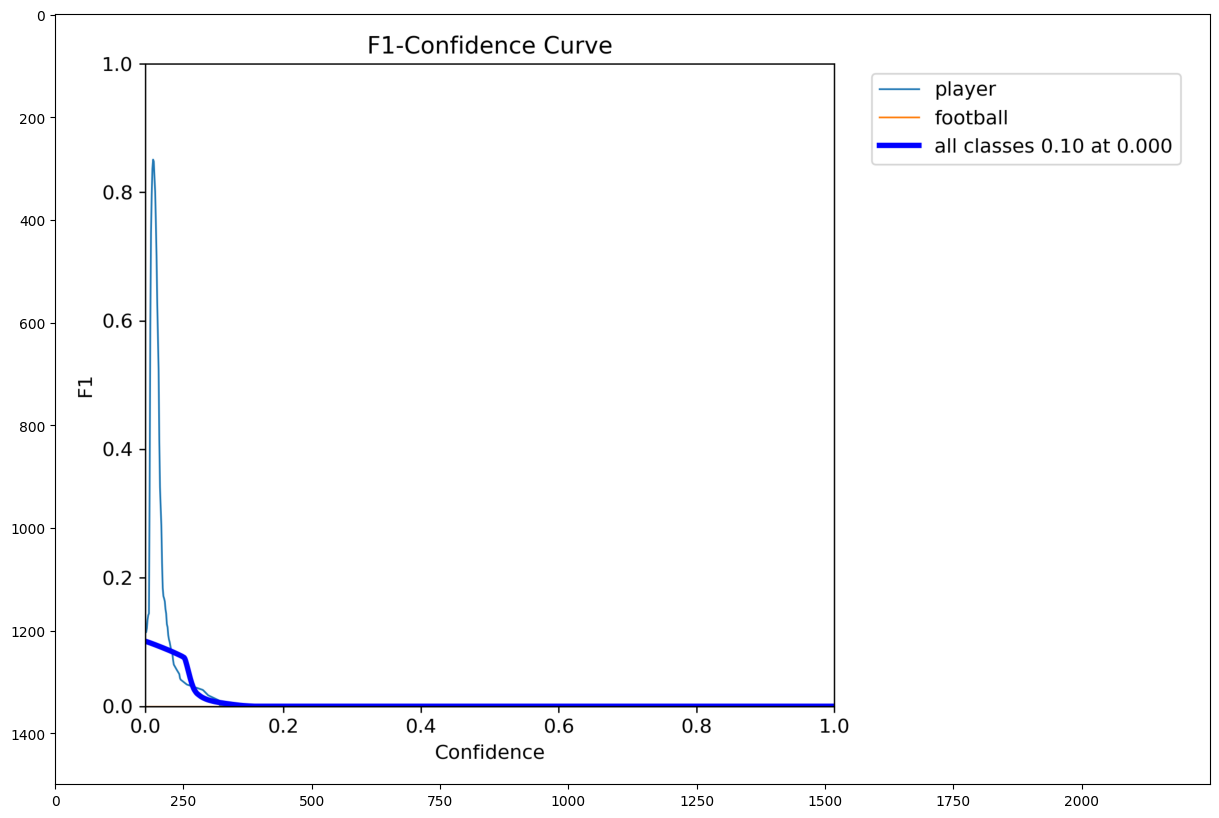

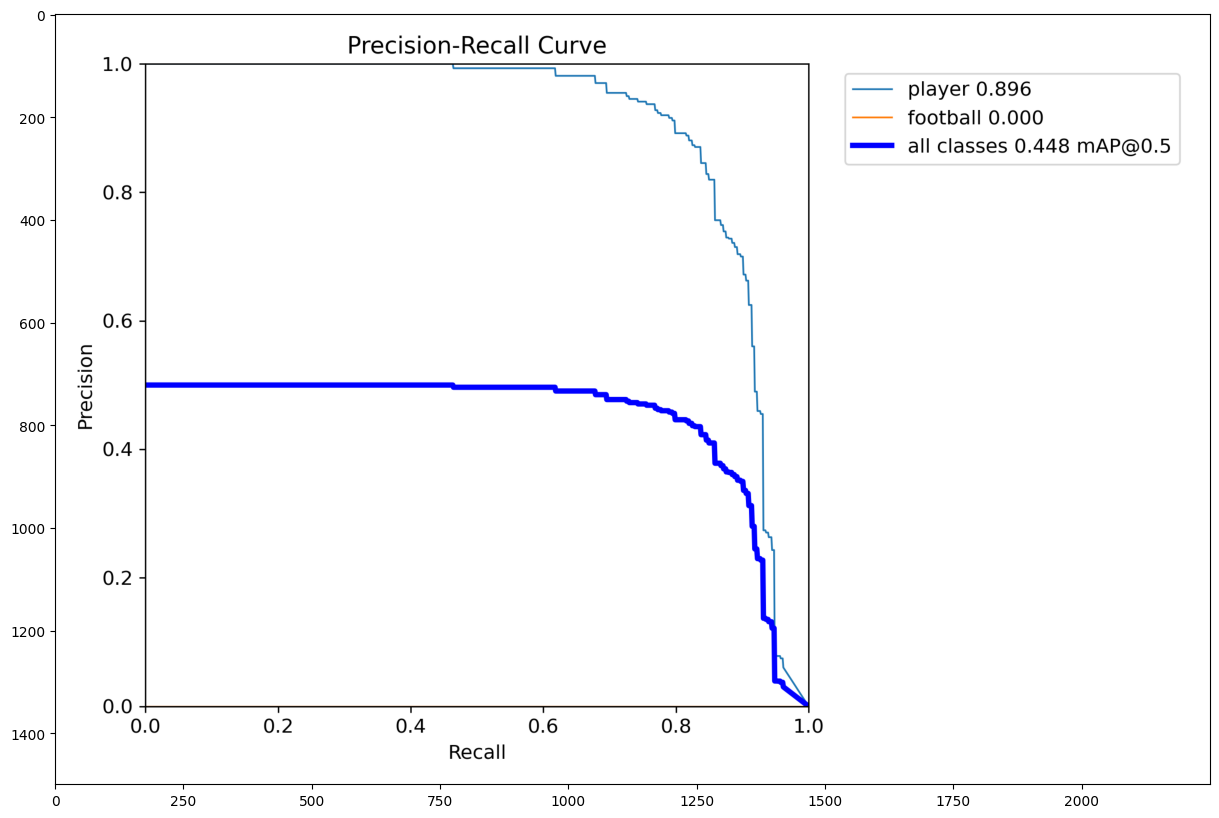

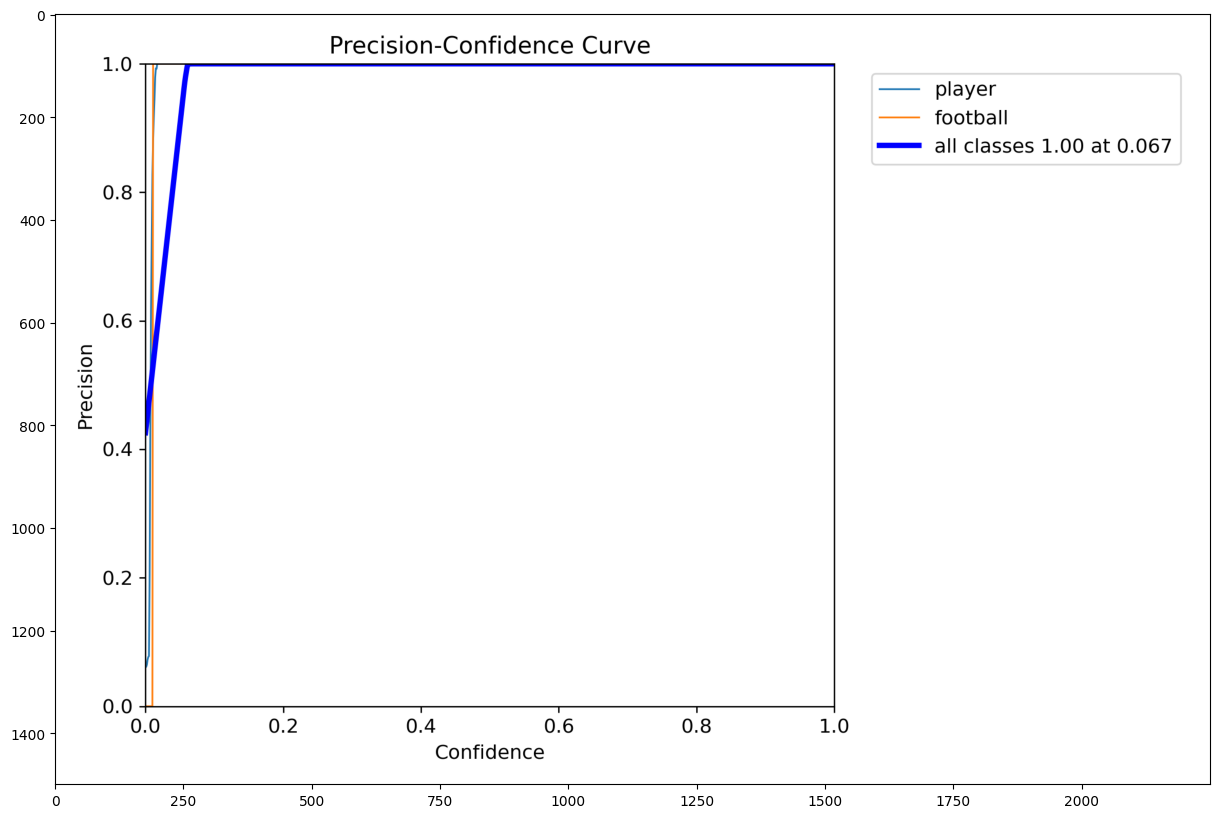

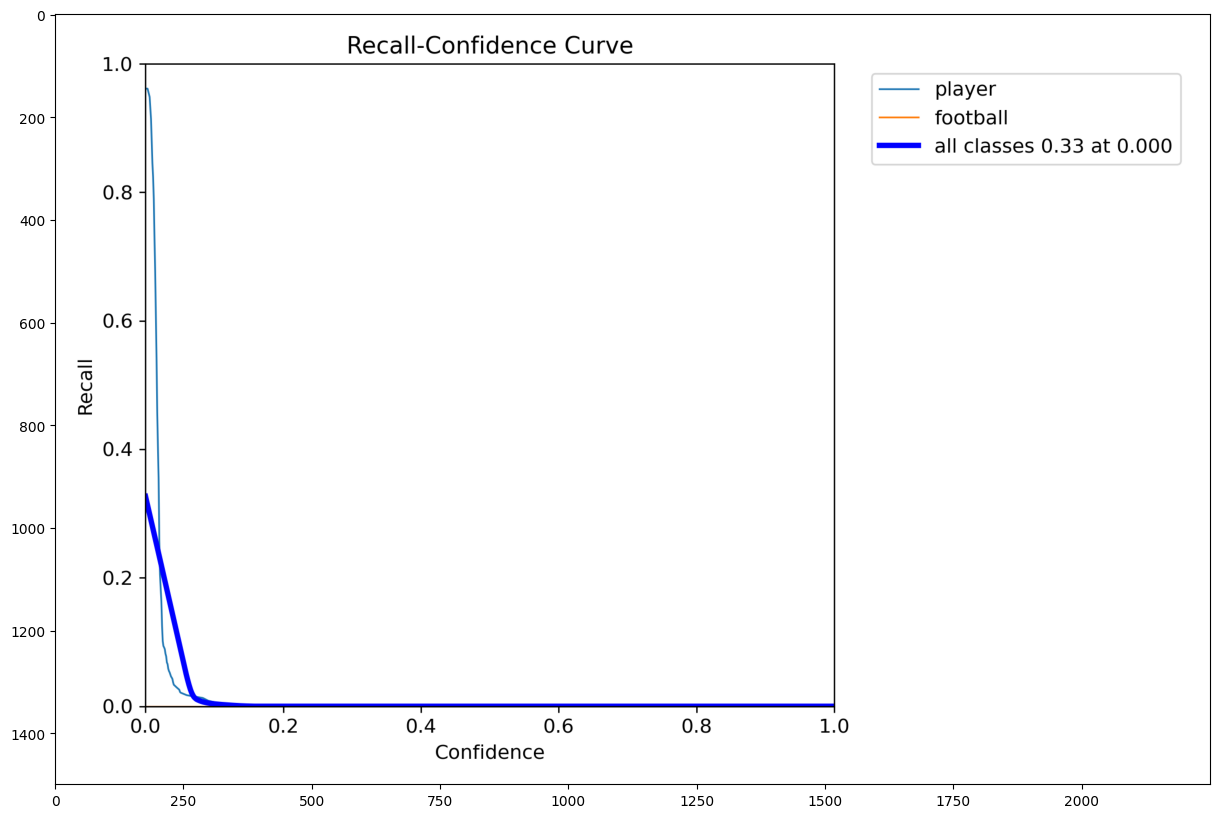

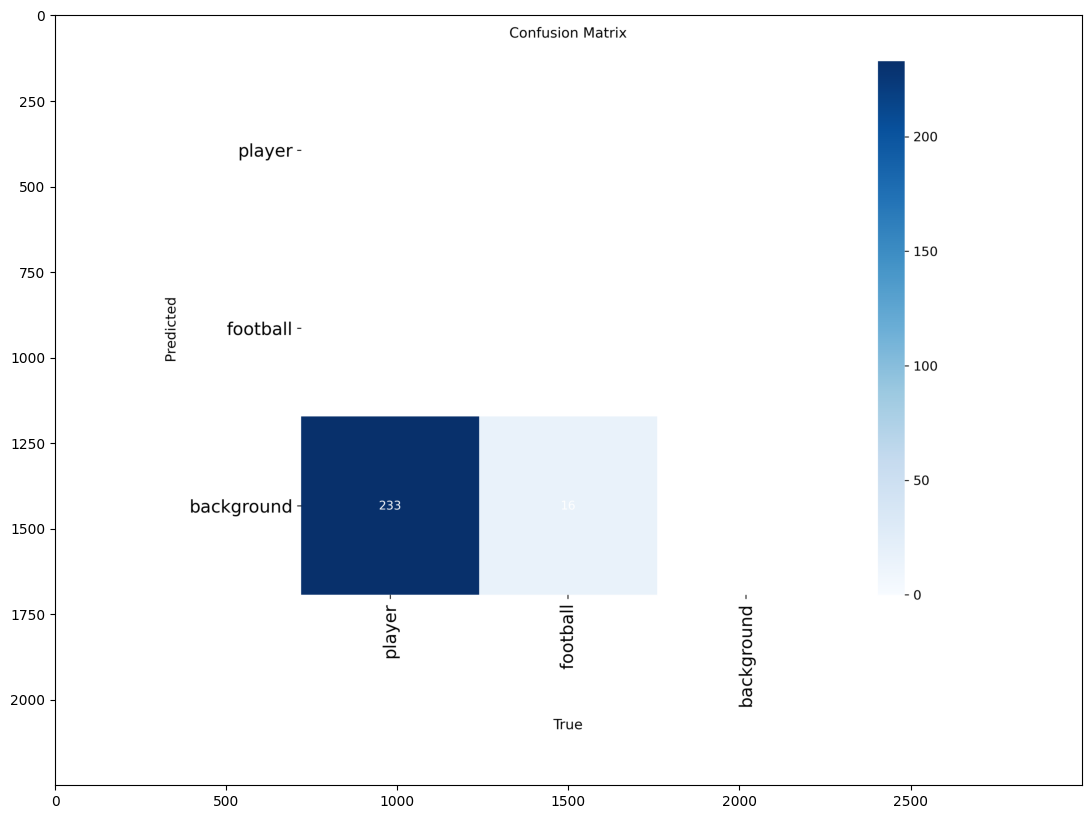

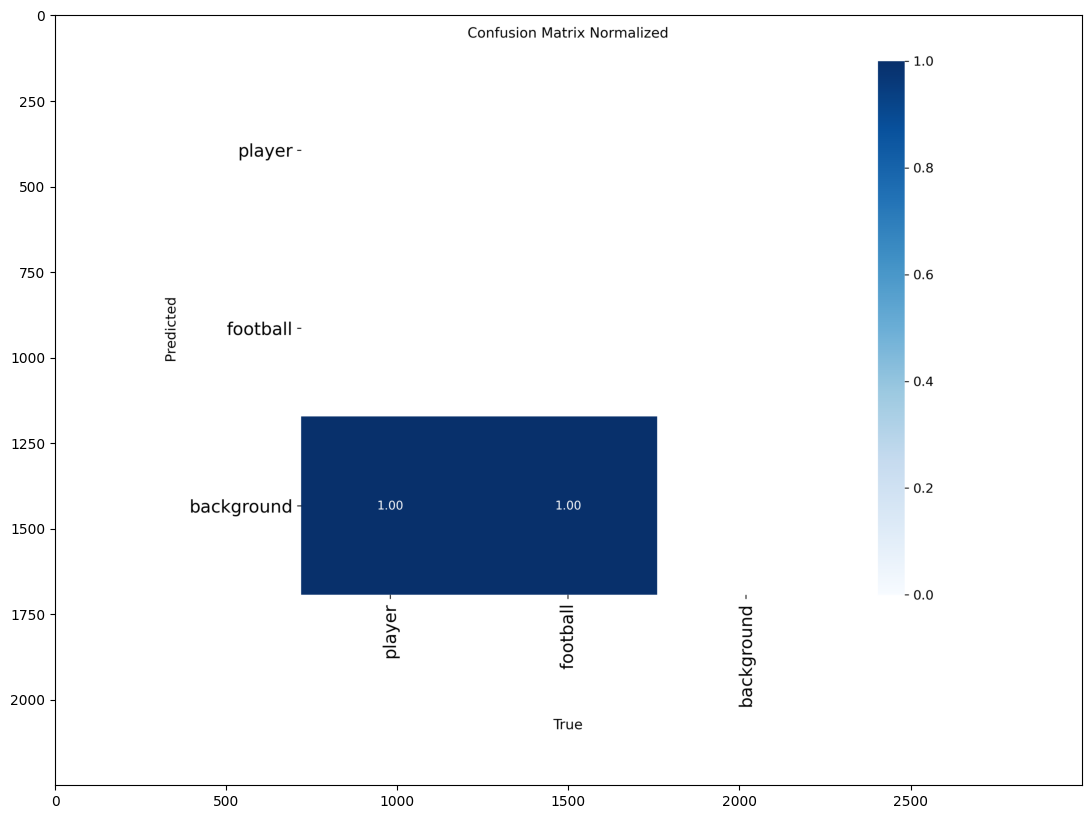

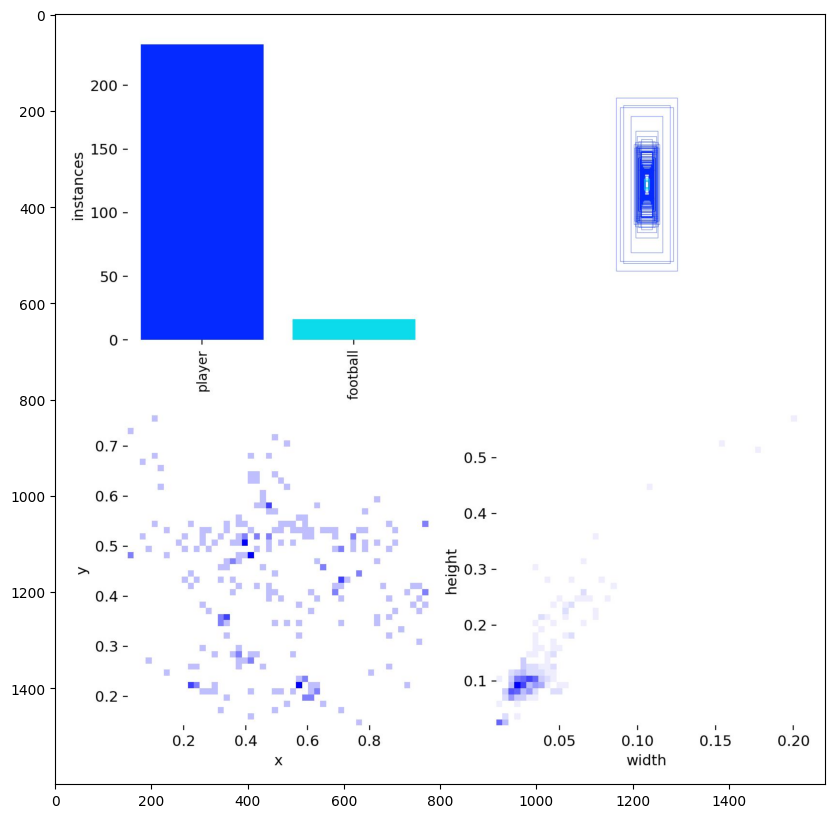

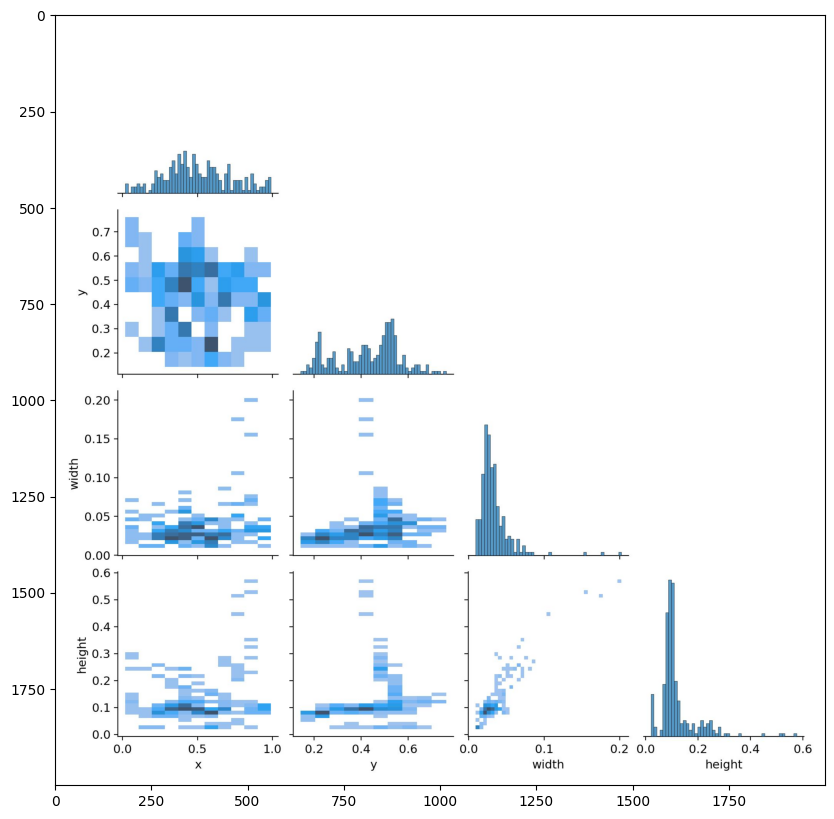

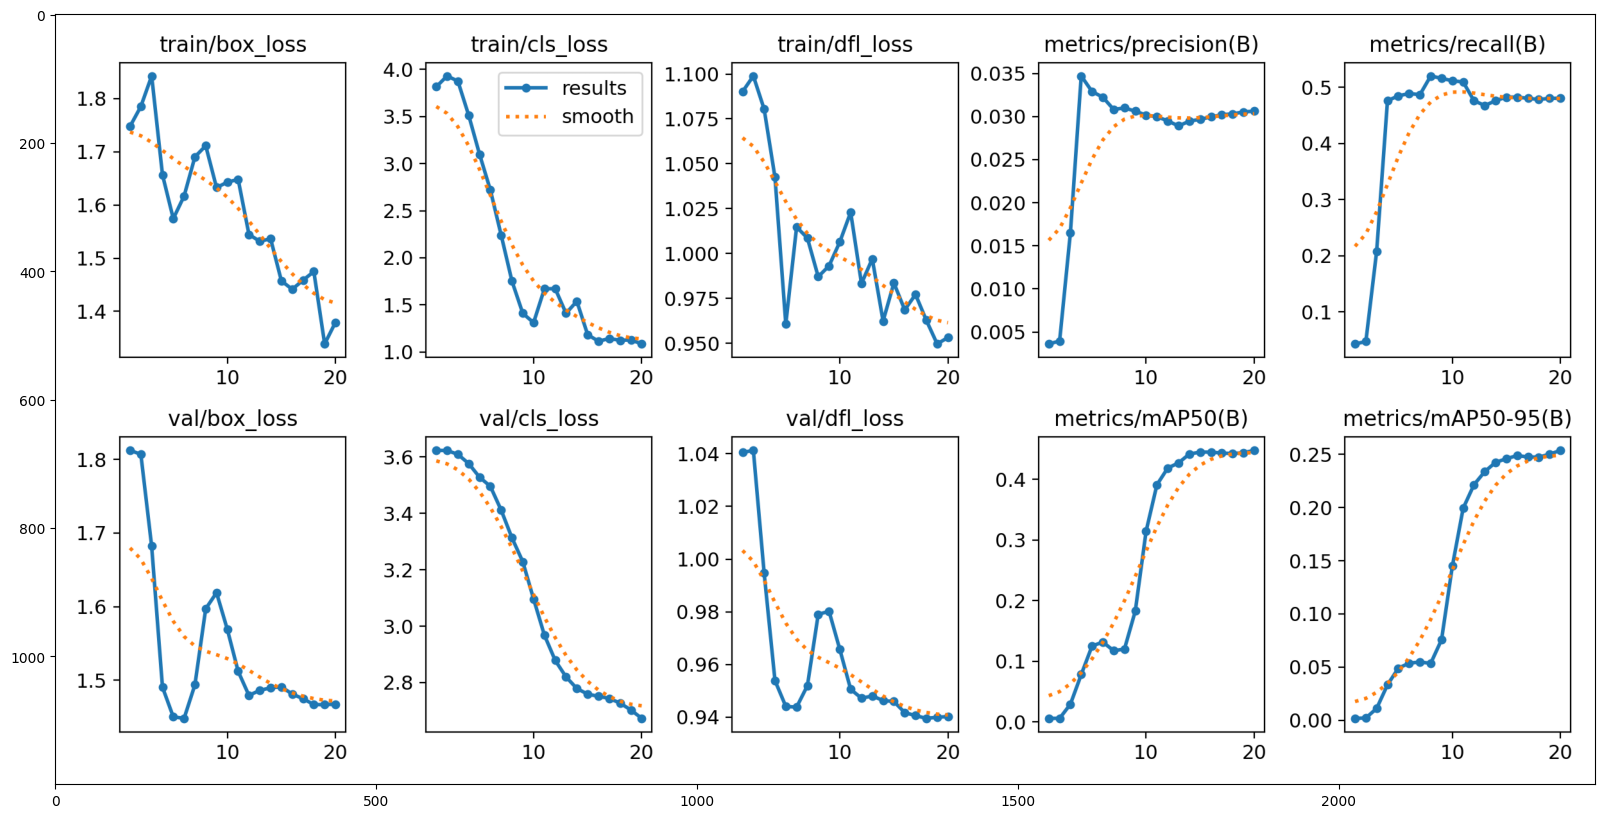

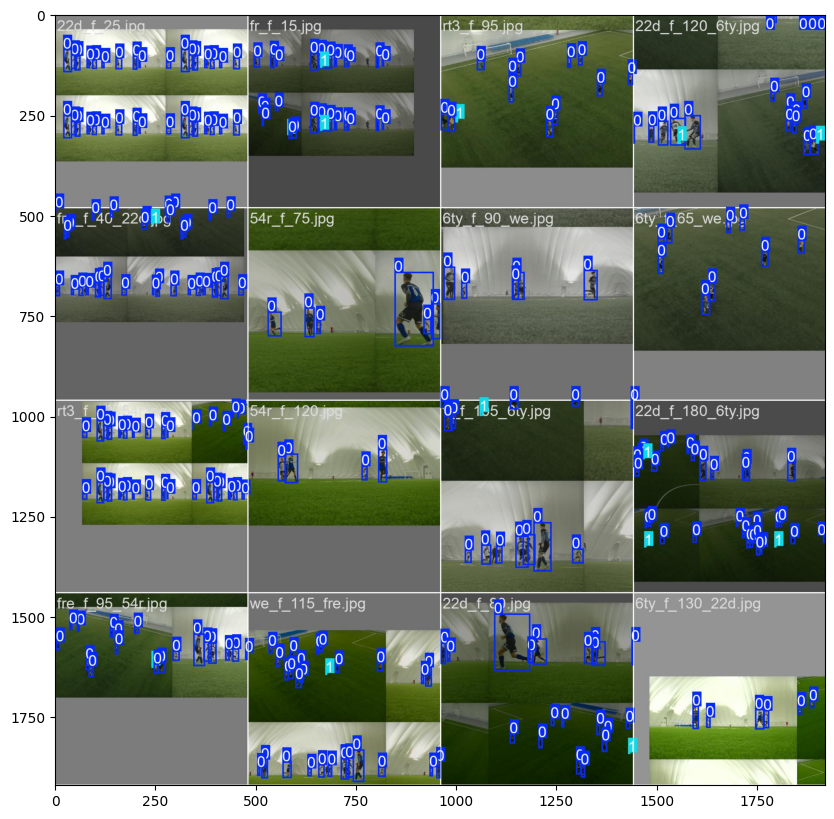

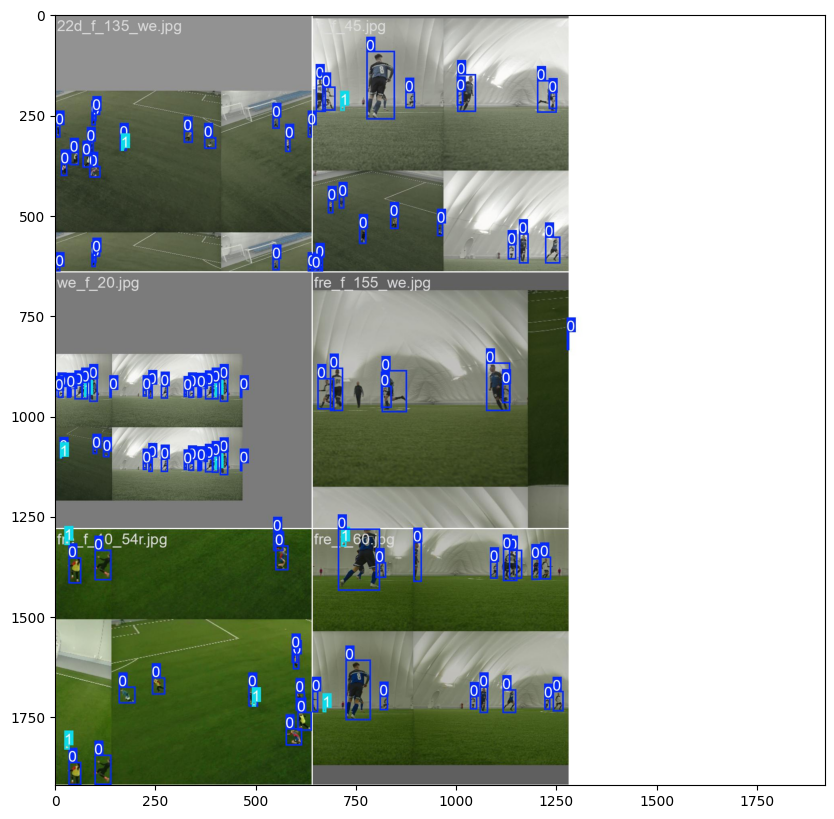

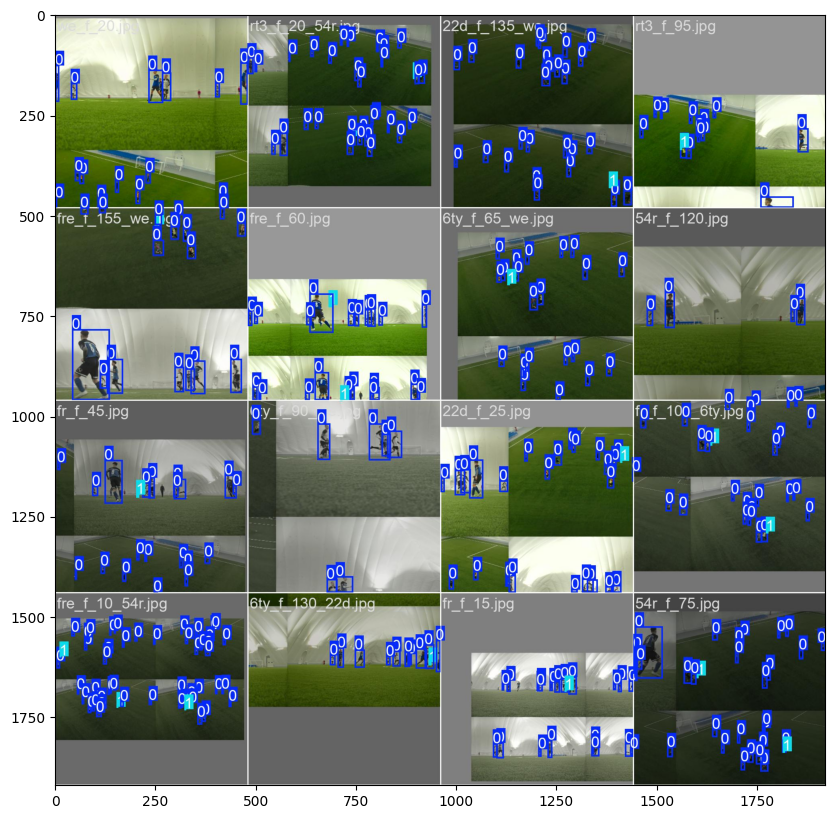

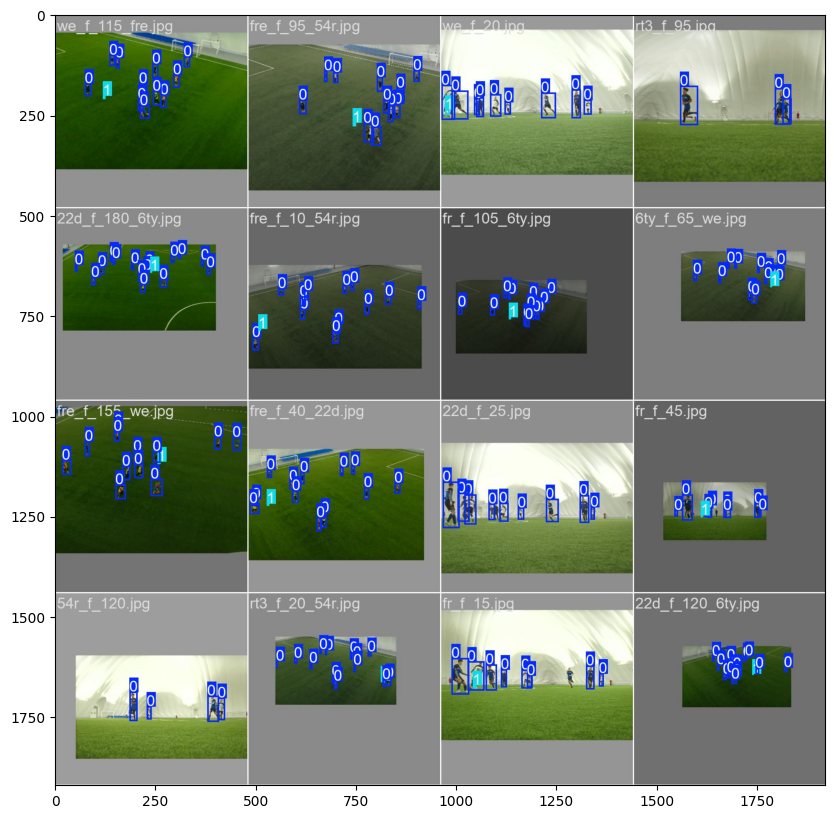

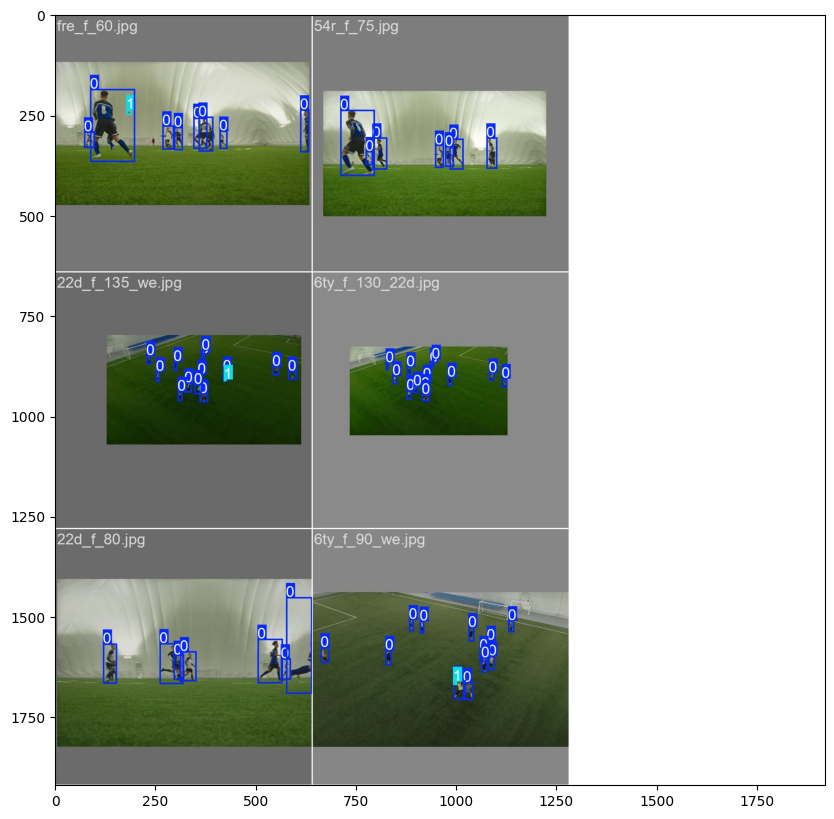

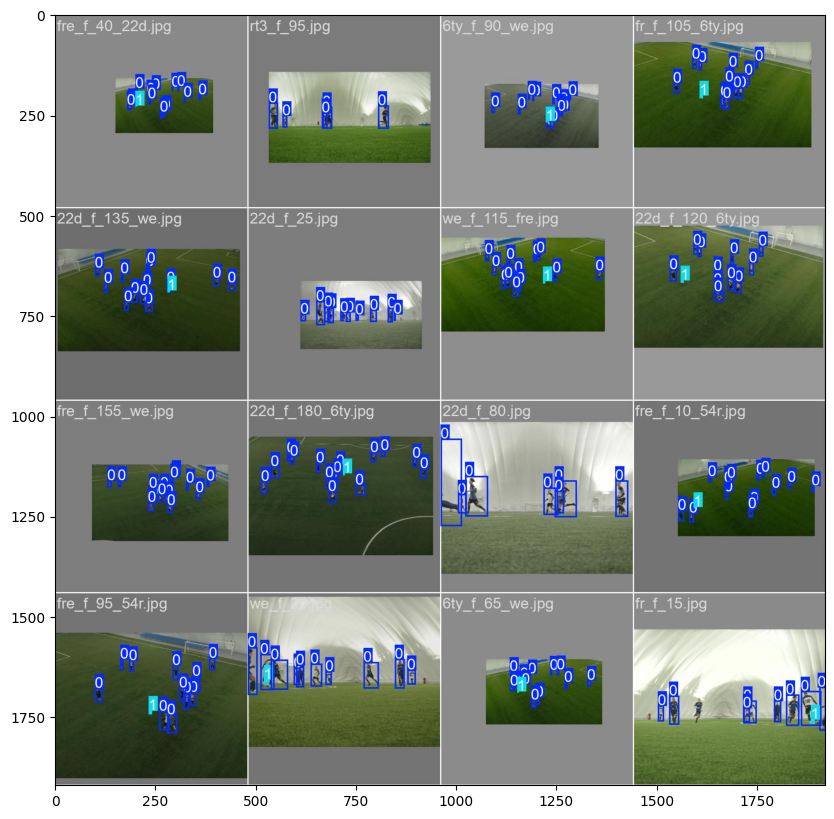

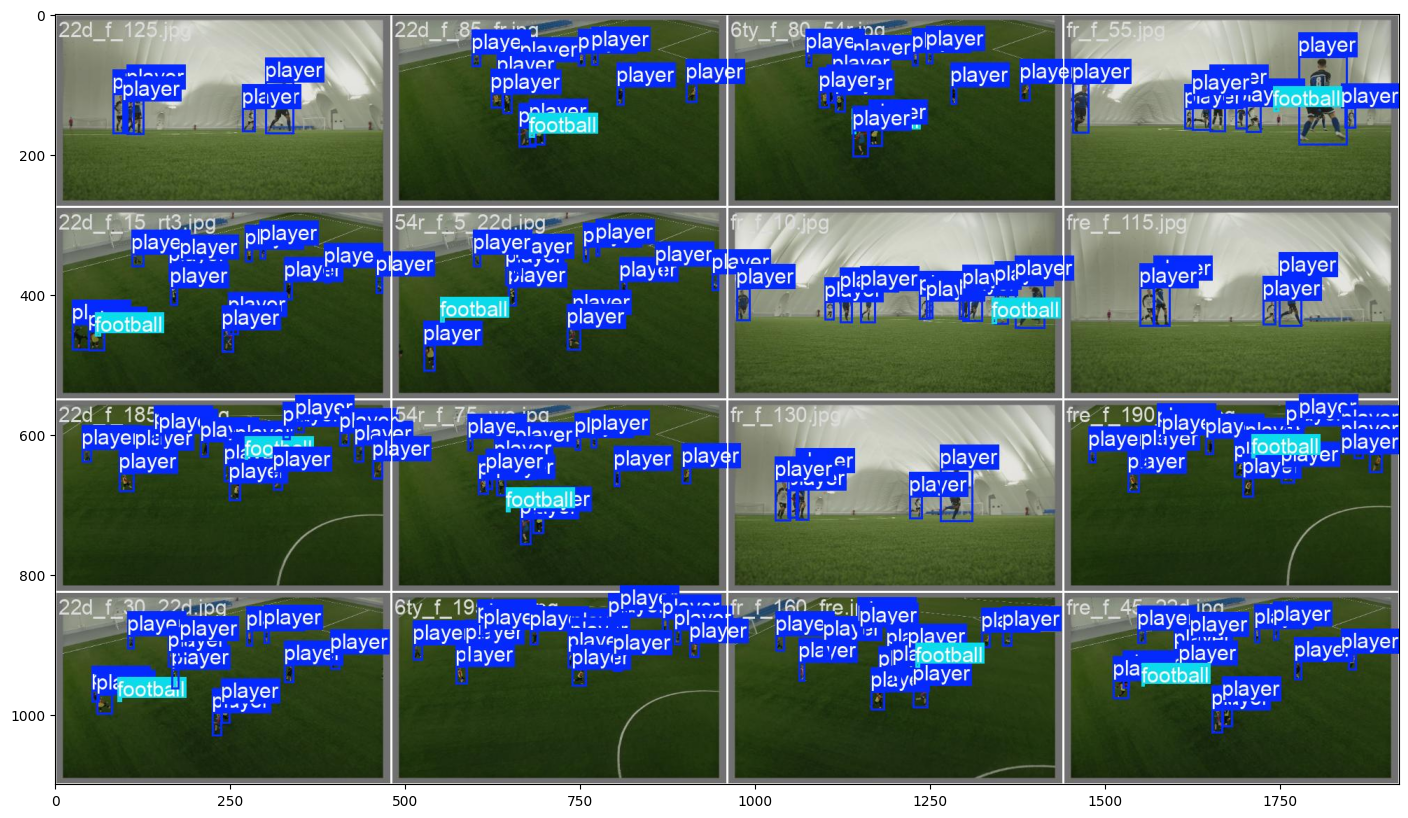

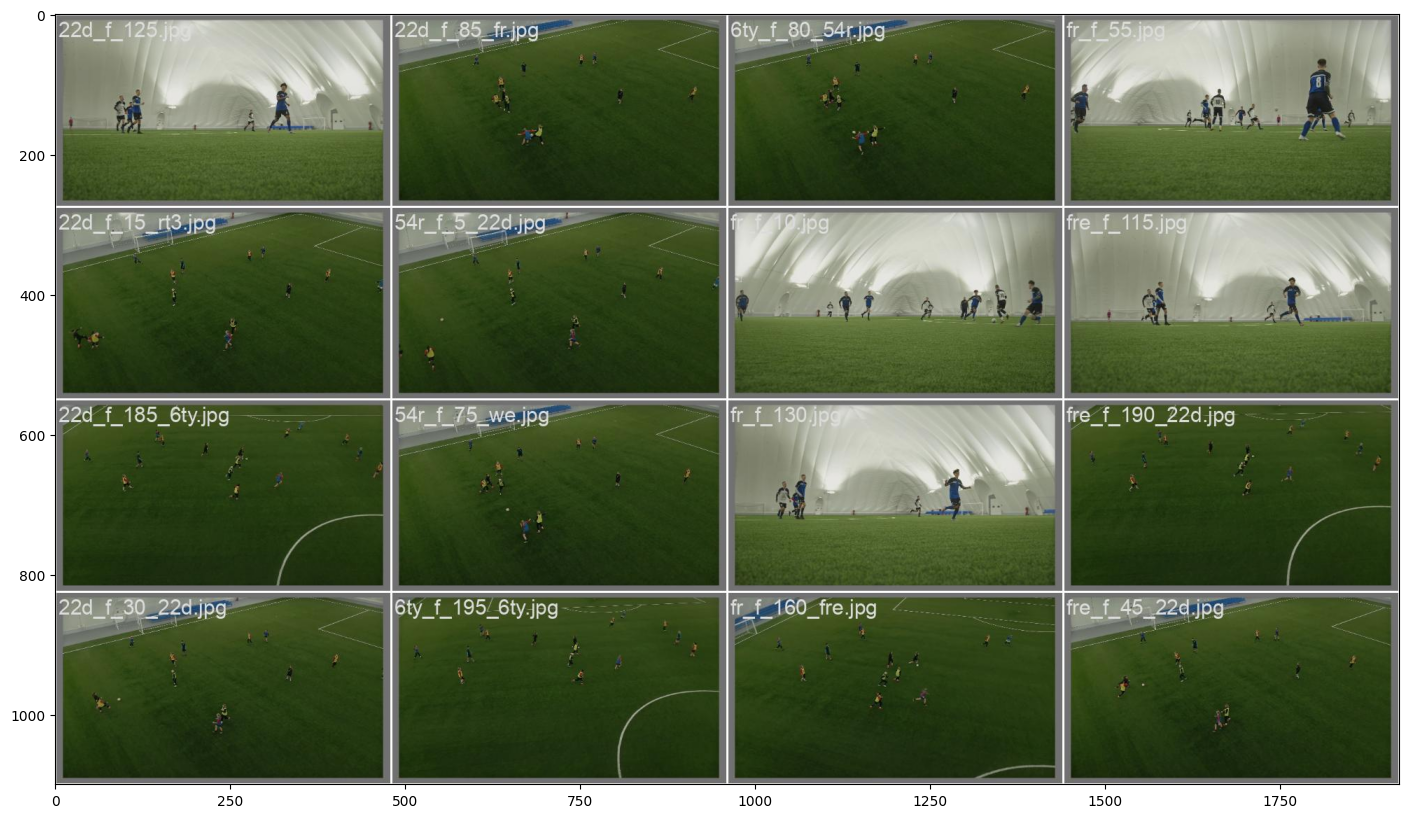

In [34]:
for path in tpaths2:
    image = Image.open(path)
    image=np.array(image)
    plt.figure(figsize=(20,10))
    plt.imshow(image)
    plt.show()

In [35]:
best_path0='runs/detect/train/weights/best.pt'
source0='datasets/test'

In [36]:
ppaths=[]
for dirname, _, filenames in os.walk(source0):
    for filename in filenames:
        if filename[-4:]=='.jpg':
            ppaths+=[(os.path.join(dirname, filename))]
ppaths=sorted(ppaths)
print(ppaths)

['datasets/test/22d_f_125_fre.jpg', 'datasets/test/22d_f_165_fr.jpg', 'datasets/test/22d_f_200_rt3.jpg', 'datasets/test/22d_f_55_22d.jpg', 'datasets/test/22d_f_90.jpg', 'datasets/test/54r_f_65.jpg', 'datasets/test/6ty_f_110_54r.jpg', 'datasets/test/6ty_f_50_we.jpg', 'datasets/test/6ty_f_85.jpg', 'datasets/test/fr_f_100_we.jpg', 'datasets/test/fr_f_140_fre.jpg', 'datasets/test/fr_f_40.jpg', 'datasets/test/fr_f_70.jpg', 'datasets/test/fre_f_145_6ty.jpg', 'datasets/test/fre_f_35.jpg', 'datasets/test/fre_f_5.jpg', 'datasets/test/fre_f_70_rt3.jpg', 'datasets/test/rt3_f_170_6ty.jpg', 'datasets/test/rt3_f_35_rt3.jpg', 'datasets/test/we_f_105.jpg', 'datasets/test/we_f_175_we.jpg', 'datasets/test/we_f_50.jpg']


In [37]:
model2 = YOLO(best_path0)
!yolo task=detect mode=predict model={best_path0} conf=0.0062 source={source0}

Ultralytics 8.3.139 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs

image 1/22 /content/datasets/test/22d_f_125_fre.jpg: 384x640 35 players, 38 footballs, 114.7ms
image 2/22 /content/datasets/test/22d_f_165_fr.jpg: 384x640 43 players, 37 footballs, 93.4ms
image 3/22 /content/datasets/test/22d_f_200_rt3.jpg: 384x640 49 players, 31 footballs, 94.0ms
image 4/22 /content/datasets/test/22d_f_55_22d.jpg: 384x640 40 players, 38 footballs, 96.3ms
image 5/22 /content/datasets/test/22d_f_90.jpg: 384x640 32 players, 33 footballs, 98.6ms
image 6/22 /content/datasets/test/54r_f_65.jpg: 384x640 35 players, 26 footballs, 94.3ms
image 7/22 /content/datasets/test/6ty_f_110_54r.jpg: 384x640 29 players, 41 footballs, 94.3ms
image 8/22 /content/datasets/test/6ty_f_50_we.jpg: 384x640 32 players, 35 footballs, 94.1ms
image 9/22 /content/datasets/test/6ty_f_85.jpg: 384x640 26 players, 38 footballs, 96.5ms
image 10/22

In [38]:
results = model2.predict(source0,conf=0.0062)
print(len(results))


image 1/22 /content/datasets/test/22d_f_125_fre.jpg: 384x640 35 players, 38 footballs, 8.3ms
image 2/22 /content/datasets/test/22d_f_165_fr.jpg: 384x640 43 players, 37 footballs, 7.5ms
image 3/22 /content/datasets/test/22d_f_200_rt3.jpg: 384x640 49 players, 31 footballs, 7.9ms
image 4/22 /content/datasets/test/22d_f_55_22d.jpg: 384x640 40 players, 38 footballs, 7.0ms
image 5/22 /content/datasets/test/22d_f_90.jpg: 384x640 32 players, 33 footballs, 13.6ms
image 6/22 /content/datasets/test/54r_f_65.jpg: 384x640 35 players, 26 footballs, 6.9ms
image 7/22 /content/datasets/test/6ty_f_110_54r.jpg: 384x640 29 players, 41 footballs, 7.0ms
image 8/22 /content/datasets/test/6ty_f_50_we.jpg: 384x640 32 players, 35 footballs, 7.0ms
image 9/22 /content/datasets/test/6ty_f_85.jpg: 384x640 26 players, 38 footballs, 6.9ms
image 10/22 /content/datasets/test/fr_f_100_we.jpg: 384x640 39 players, 36 footballs, 6.9ms
image 11/22 /content/datasets/test/fr_f_140_fre.jpg: 384x640 34 players, 37 footballs, 7

In [44]:
!yolo task=detect mode=val model={best_path0} data=football.yaml split=test

Ultralytics 8.3.139 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2588.7±1611.2 MB/s, size: 1135.4 KB)
val: Scanning /content/datasets/test... 22 images, 0 backgrounds, 0 corrupt: 100% 22/22 [00:00<00:00, 1712.56it/s]
val: New cache created: /content/datasets/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 2/2 [00:04<00:00,  2.03s/it]
                   all         22        253     0.0297      0.506       0.44      0.248
                player         22        236      0.059      0.953      0.881      0.496
              football         17         17   0.000359     0.0588   0.000192   1.92e-05
Speed: 2.6ms preprocess, 104.9ms inference, 0.0ms loss, 8.3ms postprocess per image
Results saved to runs/detect/val4
💡 Learn more at https://docs.ultralytics.com/modes/val


# 3. Улучшение бейзлайна

Улучшенный бейзлайн отличается от обычного более тонкой настройкой гиперпараметров обучения (например, оптимизированные коэффициенты потерь `box`, `cls`, `dfl`), расширенной аугментацией данных (включая `mosaic`, `mixup`, `copy-paste`), использованием cosine learning rate scheduler (`cos_lr`) и отключением mosaic-аугментации за 10 эпох до конца обучения (`close_mosaic`), что способствует более стабильному обучению и повышению точности модели. Также добавлены параметры для работы с GPU (`device='0'`) и увеличенное количество workers (`workers=4`) для ускорения обработки данных.

In [48]:
import os
import kagglehub
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from shutil import copyfile
import matplotlib.pyplot as plt
from PIL import Image

import ultralytics
from ultralytics import YOLO
ultralytics.checks()

# Загрузка данных
path = kagglehub.dataset_download("outliersloop/footballyolov8")
print("Path to dataset files:", path)

# Сбор путей к изображениям и аннотациям
ipaths = []
tpaths = []

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.lower().endswith('.jpg'):
            ipaths.append(os.path.join(dirname, filename))
        elif filename.lower().endswith('.txt'):
            tpaths.append(os.path.join(dirname, filename))

# Сортировка
ipaths = sorted(ipaths)
tpaths = sorted(tpaths)

# Подготовка структуры папок
os.makedirs('datasets', exist_ok=True)
os.makedirs('datasets/train', exist_ok=True)
os.makedirs('datasets/valid', exist_ok=True)
os.makedirs('datasets/test', exist_ok=True)

# Разделение данных (70% train, 20% valid, 10% test)
for i in range(len(ipaths)):
    ipath = ipaths[i]
    ifile = ipath.split('/')[-1]
    tpath = tpaths[i]
    tfile = tpath.split('/')[-1]

    if i % 10 < 7:  # 70% train
        copyfile(ipath, f'datasets/train/{ifile}')
        copyfile(tpath, f'datasets/train/{tfile}')
    elif i % 10 < 9:  # 20% valid
        copyfile(ipath, f'datasets/valid/{ifile}')
        copyfile(tpath, f'datasets/valid/{tfile}')
    else:  # 10% test
        copyfile(ipath, f'datasets/test/{ifile}')
        copyfile(tpath, f'datasets/test/{tfile}')

# Создание конфигурационного файла
import yaml

football_yaml = dict(
    path = os.path.abspath('.'),  # абсолютный путь к директории
    train = 'datasets/train',
    val = 'datasets/valid',
    test = 'datasets/test',
    nc = 2,
    names = ['player', 'football']
)

with open('football.yaml', 'w') as outfile:
    yaml.dump(football_yaml, outfile, default_flow_style=False)

# Инициализация модели (используем yolov8m)
model = YOLO("yolov8m.pt")

# Параметры обучения с аугментацией
train_params = {
    'data': 'football.yaml',
    'epochs': 50,
    'imgsz': 640,
    'batch': 16,
    'optimizer': 'auto',
    'lr0': 0.01,      # Начальная скорость обучения
    'lrf': 0.01,      # Конечная скорость обучения (lr0 * lrf)
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'warmup_epochs': 3.0,
    'warmup_momentum': 0.8,
    'box': 7.5,       # Коэффициент потерь для bounding box
    'cls': 0.5,       # Коэффициент потерь для классификации
    'dfl': 1.5,       # Коэффициент Distribution Focal Loss
    'hsv_h': 0.015,   # Hue augmentation
    'hsv_s': 0.7,     # Saturation augmentation
    'hsv_v': 0.4,     # Value augmentation
    'translate': 0.1, # Image translation
    'scale': 0.5,     # Image scaling
    'flipud': 0.0,    # Vertical flip probability
    'fliplr': 0.5,    # Horizontal flip probability
    'mosaic': 1.0,    # Mosaic augmentation probability
    'mixup': 0.1,     # Mixup augmentation probability
    'copy_paste': 0.1, # Copy-paste augmentation probability
    'close_mosaic': 10, # Отключить mosaic за 10 эпох до конца
    'device': '0',    # Использовать GPU
    'workers': 4,     # Количество workers для загрузки данных
    'single_cls': False,
    'cos_lr': True,   # Использовать cosine learning rate scheduler
    'val': True,      # Проводить валидацию во время обучения
    'plots': True    # Сохранять графики обучения
}

# Обучение модели
results = model.train(**train_params)

# Проверка лучшей модели
best_model_path = 'runs/detect/train/weights/best.pt'
model = YOLO(best_model_path)

# Валидация на тестовом наборе
metrics = model.val(
    data='football.yaml',
    split='test',
    conf=0.25,  # confidence threshold
    iou=0.6,    # NMS IoU threshold
    plots=True  # сохранить графики
)

# Прогнозирование на тестовых данных
test_source = 'datasets/test'
results = model.predict(
    source=test_source,
    conf=0.25,    # confidence threshold
    iou=0.45,     # NMS IoU threshold
    imgsz=640,    # inference size
    save=True,    # save predictions
    save_txt=True,# save results as .txt
    save_conf=True,# save confidence scores
    augment=True  # augmented inference
)

Ultralytics 8.3.139 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.9/112.6 GB disk)
Path to dataset files: /kaggle/input/footballyolov8
Ultralytics 8.3.139 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=football.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, mu

train: Scanning /content/datasets/train.cache... 54 images, 0 backgrounds, 0 corrupt: 100%|██████████| 54/54 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1326.8±1221.1 MB/s, size: 1207.9 KB)


val: Scanning /content/datasets/valid.cache... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.16G      1.898      1.619      1.265        136        640: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         30        326      0.465      0.438      0.467      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.42G      1.619      1.558      1.111        121        640: 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         30        326       0.93      0.472      0.458      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.42G      1.451     0.9763      1.021        145        640: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

                   all         30        326      0.478      0.547      0.559      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.47G      1.419     0.8282     0.9942        112        640: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all         30        326      0.491      0.642      0.556       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.48G      1.499     0.8884      1.011        179        640: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all         30        326      0.751      0.632      0.634      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.55G      1.526     0.8157      1.044        147        640: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

                   all         30        326      0.775      0.531        0.6      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.76G       1.48     0.8016      0.989        190        640: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

                   all         30        326      0.723      0.715      0.698      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.82G       1.37     0.6809     0.9904        139        640: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

                   all         30        326      0.825      0.741      0.763      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.82G      1.325     0.6837     0.9646        142        640: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

                   all         30        326      0.945      0.764      0.791      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.82G      1.372     0.6766     0.9914         99        640: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

                   all         30        326      0.918       0.73      0.754      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.82G      1.363     0.6577     0.9858        135        640: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         30        326      0.857      0.693       0.74      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.82G      1.352      0.661     0.9677        152        640: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all         30        326      0.873      0.788      0.811      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.82G      1.355     0.6677      1.003        143        640: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

                   all         30        326      0.839       0.82       0.81      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.97G      1.346     0.6797      0.968        152        640: 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all         30        326      0.771      0.789      0.797      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.04G       1.36     0.7014     0.9894        117        640: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all         30        326      0.829      0.779      0.805      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.04G      1.418     0.7075     0.9764        167        640: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all         30        326      0.779      0.791      0.736      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.04G      1.375     0.6814     0.9917        112        640: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all         30        326      0.792       0.68      0.673      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.04G      1.351     0.6457     0.9984        122        640: 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

                   all         30        326       0.79      0.669      0.631      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.04G      1.382     0.6879     0.9675        161        640: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all         30        326      0.844       0.69      0.682      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.04G      1.344     0.6342     0.9585        205        640: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all         30        326      0.878      0.695      0.734      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.04G      1.302     0.6296     0.9509        141        640: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all         30        326      0.892      0.727      0.719      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.04G      1.279      0.612     0.9665        145        640: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

                   all         30        326      0.874      0.743      0.741       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.04G       1.28     0.6433     0.9935        109        640: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all         30        326      0.882      0.764      0.769      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.04G      1.299     0.6284     0.9589        111        640: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all         30        326      0.934      0.782      0.789      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       7.1G      1.312     0.6222     0.9696        181        640: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all         30        326      0.965      0.823      0.843      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       7.1G      1.294      0.593      0.964        124        640: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all         30        326      0.973      0.836      0.843      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       7.1G      1.302     0.6095     0.9638        205        640: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all         30        326      0.983      0.832      0.845      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.17G      1.231     0.5657     0.9599        184        640: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

                   all         30        326      0.979      0.835      0.841      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.17G      1.231     0.5584     0.9546        121        640: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

                   all         30        326       0.97      0.843      0.845      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.17G      1.314     0.5944     0.9577        190        640: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

                   all         30        326       0.97      0.842       0.85      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.17G      1.255     0.5884     0.9965         75        640: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

                   all         30        326      0.983      0.843      0.849      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.17G       1.24     0.5774     0.9421        131        640: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]

                   all         30        326       0.95       0.82      0.806      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.17G      1.199     0.5568     0.9357        122        640: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all         30        326      0.948      0.795      0.782      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.17G      1.187     0.5462     0.9529         92        640: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all         30        326      0.928      0.797      0.784      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.17G      1.195     0.5581     0.9501        101        640: 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

                   all         30        326      0.942      0.797      0.785       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.17G      1.219     0.5444     0.9377         95        640: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

                   all         30        326      0.944       0.82       0.81      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.17G      1.181     0.5312     0.9336        112        640: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         30        326      0.948      0.822      0.813      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.17G      1.169     0.5207     0.9225        117        640: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all         30        326      0.945      0.817      0.814      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.17G      1.173     0.5195      0.943        163        640: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

                   all         30        326      0.915      0.816       0.81      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.17G      1.136     0.5099     0.9166        128        640: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

                   all         30        326       0.95      0.818      0.814      0.475


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.17G      1.117     0.5365     0.9254         77        640: 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         30        326      0.918      0.822      0.814      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.17G       1.19     0.5326      0.959         68        640: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all         30        326      0.921      0.822      0.806       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.17G      1.104     0.5131     0.9182         63        640: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

                   all         30        326       0.95      0.847      0.863      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.17G      1.126     0.5035     0.9399         65        640: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all         30        326       0.95      0.847       0.86      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.17G      1.114     0.4925     0.9088         67        640: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         30        326      0.949      0.847      0.858      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.17G      1.073     0.4825     0.9091         59        640: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

                   all         30        326      0.948      0.845      0.855      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.17G      1.105     0.4667     0.9241         62        640: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

                   all         30        326      0.952      0.845      0.856      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.17G      1.094     0.4944     0.9383         57        640: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all         30        326      0.953      0.845      0.856      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.17G       1.08     0.4637     0.9184         78        640: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all         30        326      0.954      0.845      0.856      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.17G      1.073      0.467     0.9065         73        640: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         30        326      0.954      0.862       0.88      0.494



50 epochs completed in 0.109 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 52.0MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.139 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


                   all         30        326      0.954      0.862       0.88      0.496
                player         30        306      0.972       0.99      0.994      0.687
              football         20         20      0.936      0.734      0.766      0.305
Speed: 0.2ms preprocess, 7.0ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train3
Ultralytics 8.3.139 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2906.9±663.7 MB/s, size: 1215.0 KB)


val: Scanning /content/datasets/test.cache... 26 images, 0 backgrounds, 0 corrupt: 100%|██████████| 26/26 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


                   all         26        303          0          0          0          0
                player         26        283          0          0          0          0
              football         20         20          0          0          0          0
Speed: 3.4ms preprocess, 3.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/val6

image 1/26 /content/datasets/test/22d_f_125_fre.jpg: 384x640 (no detections), 97.9ms
image 2/26 /content/datasets/test/22d_f_165_fr.jpg: 384x640 (no detections), 34.0ms
image 3/26 /content/datasets/test/22d_f_200_rt3.jpg: 384x640 (no detections), 21.4ms
image 4/26 /content/datasets/test/22d_f_25.jpg: 384x640 (no detections), 21.0ms
image 5/26 /content/datasets/test/22d_f_55_22d.jpg: 384x640 (no detections), 22.5ms
image 6/26 /content/datasets/test/22d_f_90.jpg: 384x640 (no detections), 21.4ms
image 7/26 /content/datasets/test/54r_f_65.jpg: 384x640 (no detections), 21.7ms
image 8/26 /content/datasets/test/54r_

# 4. Имплементация алгоритма машинного обучения

In [57]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import auc

# =============================================
# 1. Загрузка и обработка данных (YOLO-формат)
# =============================================

def load_yolo_annotations(annotation_dir, image_dir):
    """
    Загрузка аннотаций в формате YOLO (файлы .txt) и преобразование в абсолютные координаты.
    Возвращает словарь: {image_name: [{"class": int, "bbox": [x1,y1,x2,y2]}, ...]}
    """
    gt_data = {}
    for txt_file in os.listdir(annotation_dir):
        if not txt_file.endswith('.txt'):
            continue

        image_name = txt_file.replace('.txt', '.jpg')
        image_path = os.path.join(image_dir, image_name)
        if not os.path.exists(image_path):
            continue

        with open(os.path.join(annotation_dir, txt_file), 'r') as f:
            lines = f.readlines()

        bboxes = []
        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                continue  # Пропускаем некорректные строки

            class_id, x_center, y_center, w, h = map(float, parts)
            img = cv2.imread(image_path)
            img_h, img_w = img.shape[:2]

            # Конвертация из YOLO-формата (относительные координаты) в абсолютные
            x1 = int((x_center - w / 2) * img_w)
            y1 = int((y_center - h / 2) * img_h)
            x2 = int((x_center + w / 2) * img_w)
            y2 = int((y_center + h / 2) * img_h)

            bboxes.append({"class": int(class_id), "bbox": [x1, y1, x2, y2]})

        gt_data[image_name] = bboxes
    return gt_data

# Пример загрузки данных
gt_annotations = load_yolo_annotations("datasets/test", "datasets/test")

# =============================================
# 2. Функции для расчета IoU и метрик
# =============================================

def calculate_iou(box1, box2):
    """Расчет Intersection over Union (IoU) для двух bounding box'ов."""
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    # Пересечение
    inter_x1 = max(x1_min, x2_min)
    inter_y1 = max(y1_min, y2_min)
    inter_x2 = min(x1_max, x2_max)
    inter_y2 = min(y1_max, y2_max)

    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    if inter_area == 0:
        return 0.0

    # Объединение
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area

def calculate_ap(gt_boxes, pred_boxes, iou_threshold=0.5):
    """Расчет Average Precision (AP) для одного изображения и одного класса."""
    if not gt_boxes or not pred_boxes:
        return 0.0

    # Сортируем предсказания по уверенности (confidence)
    pred_boxes_sorted = sorted(pred_boxes, key=lambda x: x["confidence"], reverse=True)

    tp = np.zeros(len(pred_boxes_sorted))
    fp = np.zeros(len(pred_boxes_sorted))
    gt_matched = [False] * len(gt_boxes)

    for i, pred_box in enumerate(pred_boxes_sorted):
        best_iou = 0
        best_gt_idx = -1

        for j, gt_box in enumerate(gt_boxes):
            if gt_matched[j]:
                continue  # Этот GT уже сопоставлен

            iou = calculate_iou(pred_box["bbox"], gt_box["bbox"])
            if iou > best_iou and iou >= iou_threshold:
                best_iou = iou
                best_gt_idx = j

        if best_gt_idx != -1:
            tp[i] = 1
            gt_matched[best_gt_idx] = True  # Помечаем GT как сопоставленный
        else:
            fp[i] = 1

    # Кумулятивные суммы TP и FP
    tp_cumsum = np.cumsum(tp)
    fp_cumsum = np.cumsum(fp)

    # Precision и Recall
    precision = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-10)
    recall = tp_cumsum / len(gt_boxes)

    # AP (Area Under Precision-Recall Curve)
    ap = auc(recall, precision)
    return ap

def calculate_map(gt_data, pred_data, num_classes=2, iou_thresholds=None):
    """Расчет mAP для всех классов и IoU-порогов."""
    if iou_thresholds is None:
        iou_thresholds = np.linspace(0.5, 0.95, 10)  # Для mAP50-95

    aps = {iou: [] for iou in iou_thresholds}

    for iou in iou_thresholds:
        for class_id in range(num_classes):
            ap_list = []
            for image_name, gt_boxes in gt_data.items():
                # Фильтруем GT и Pred по классу
                gt_class_boxes = [box for box in gt_boxes if box["class"] == class_id]
                pred_class_boxes = [box for box in pred_data.get(image_name, [])
                                   if box["class"] == class_id]

                ap = calculate_ap(gt_class_boxes.copy(), pred_class_boxes, iou)
                ap_list.append(ap)

            if ap_list:
                aps[iou].append(np.mean(ap_list))

    # mAP50 и mAP50-95
    map50 = np.mean(aps[0.5])
    map50_95 = np.mean([np.mean(aps[iou]) for iou in iou_thresholds])
    return map50, map50_95

# =============================================
# 3. Пример использования (с синтетическими данными)
# =============================================

# Пример предсказаний модели (можно заменить на реальные предсказания YOLO)
pred_data = {
    "image1.jpg": [
        {"class": 0, "bbox": [100, 100, 200, 200], "confidence": 0.9},
        {"class": 1, "bbox": [150, 150, 250, 250], "confidence": 0.8},
    ],
    "image2.jpg": [
        {"class": 0, "bbox": [50, 50, 150, 150], "confidence": 0.7},
    ],
}

# Расчет mAP
map50, map50_95 = calculate_map(gt_annotations, pred_data)
print(f"mAP50: {map50:.4f}")
print(f"mAP50-95: {map50_95:.4f}")

# =============================================
# 4. Визуализация Precision-Recall кривой (опционально)
# =============================================

def plot_pr_curve(gt_boxes, pred_boxes, iou_threshold=0.5):
    """Построение Precision-Recall кривой для одного класса."""
    if not gt_boxes or not pred_boxes:
        return

    pred_boxes_sorted = sorted(pred_boxes, key=lambda x: x["confidence"], reverse=True)

    tp = np.zeros(len(pred_boxes_sorted))
    fp = np.zeros(len(pred_boxes_sorted))
    gt_matched = [False] * len(gt_boxes)

    for i, pred_box in enumerate(pred_boxes_sorted):
        best_iou = 0
        best_gt_idx = -1

        for j, gt_box in enumerate(gt_boxes):
            if gt_matched[j]:
                continue

            iou = calculate_iou(pred_box["bbox"], gt_box["bbox"])
            if iou > best_iou and iou >= iou_threshold:
                best_iou = iou
                best_gt_idx = j

        if best_gt_idx != -1:
            tp[i] = 1
            gt_matched[best_gt_idx] = True
        else:
            fp[i] = 1

    tp_cumsum = np.cumsum(tp)
    fp_cumsum = np.cumsum(fp)

    precision = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-10)
    recall = tp_cumsum / len(gt_boxes)

    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve (IoU={iou_threshold})')
    plt.grid()
    plt.show()

# Пример визуализации для одного класса и изображения
plot_pr_curve(
    gt_boxes=[box for box in gt_annotations["image1.jpg"] if box["class"] == 0],
    pred_boxes=[box for box in pred_data["image1.jpg"] if box["class"] == 0],
    iou_threshold=0.5
)

mAP50: 0.0000
mAP50-95: 0.0000


KeyError: 'image1.jpg'